# UCI dataset

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm

In [3]:
df = pd.read_csv('forestfires.csv')
df.info

<bound method DataFrame.info of      X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]>

In [5]:
def MeanError(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

In [6]:
def mean_absolute_percentage_error(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / (y_test+10e-1)) ) * 100

## Encoding Data

In [4]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
df['month']= label_encoder.fit_transform(df['month'])
df['day']= label_encoder.fit_transform(df['day'])
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy()
# df.info


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## analyzing data

In [42]:
import plotly.express as px
fig = px.scatter_3d(df,x = 'DMC', y = 'DC', z= 'area',color='temp', width=800, height=800)
fig.show()

In [39]:
fig = px.histogram(df, x='area', range_x=[1,1000], log_x=True)
fig.show()

In [10]:
#Best Features - Univariate statistical selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

#apply SelectKBest class to extract top 10 best features
feature_names = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain,area']
bestfeatures = SelectKBest(score_func=chi2, k=12)
fit = bestfeatures.fit(X,np.array(Y).astype(int))
dfscores = pd.DataFrame(fit.scores_)
df_specs = pd.Series(feature_names).astype(str)
#concat two dataframes for better visualization 
featureScores = pd.concat([df_specs,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print 10 best features
px.bar(featureScores, y='Score', x=feature_names, color=feature_names)

      Feature        Score
6          DC  5519.298286
5         DMC  2354.025363
9          RH   385.465278
2       month   263.339617
11  rain,area   230.570175
7         ISI   141.603429
8        temp   134.638938
3         day    75.324026
0           X    65.588459
10       wind    57.498686
1           Y    22.311578
4        FFMC    11.179406


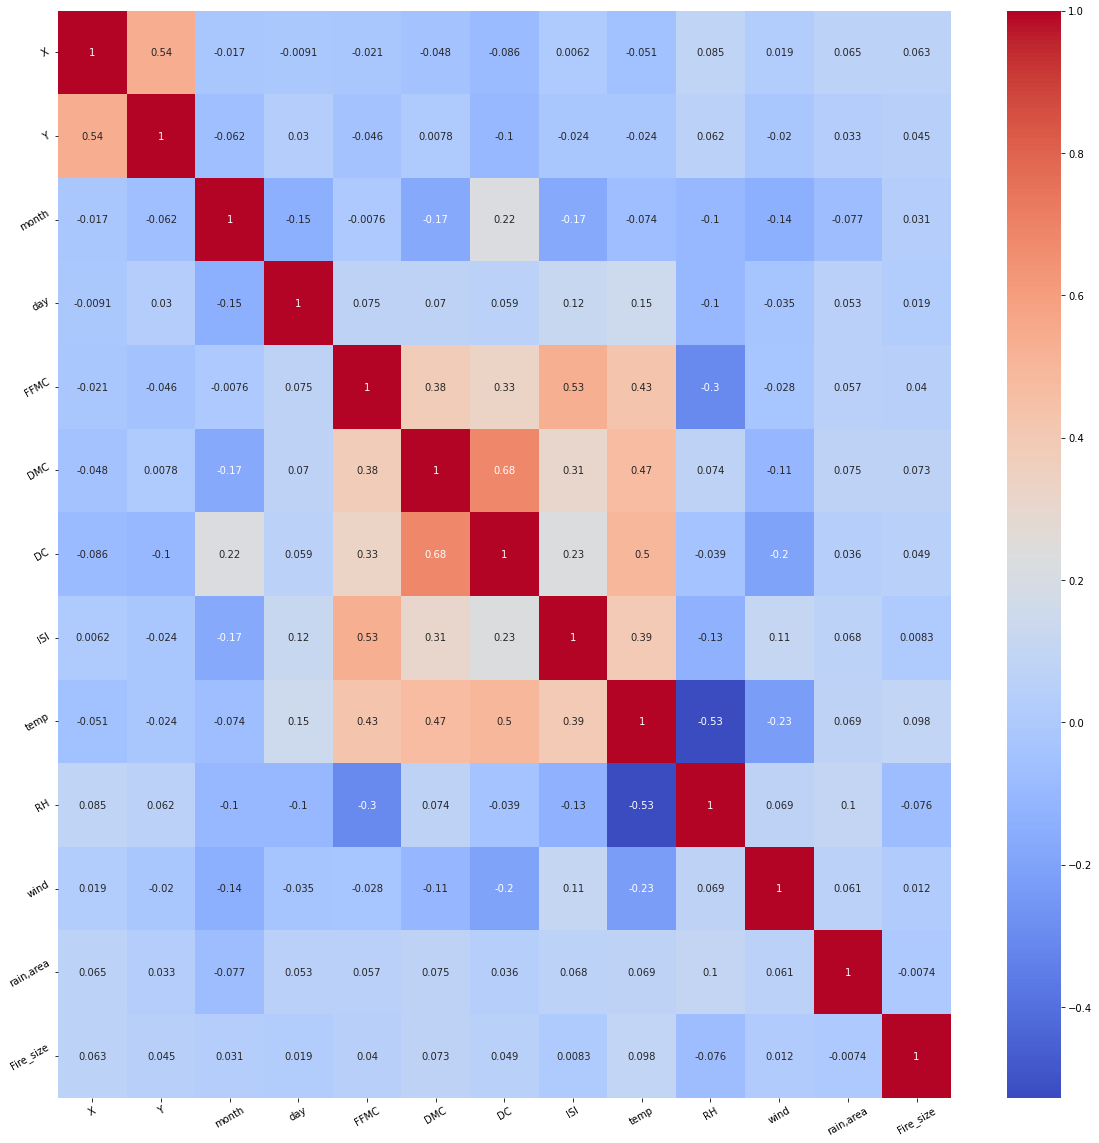

In [11]:
# Best feautres - correlation heatmap
import seaborn as sns
feature_names = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain,area','Fire_size']
data = np.concatenate((X,Y.reshape(-1,1)),axis=1)
corrmat = np.corrcoef(data.T)
plt.figure(figsize=(20,20))
g=sns.heatmap(corrmat,annot=True,cmap="coolwarm")
g.set_xticklabels(feature_names,rotation=30)
g.set_yticklabels(feature_names,rotation=30)
plt.savefig('corr_UCI.png')
plt.show()


## Linear regression

700.4133081403135


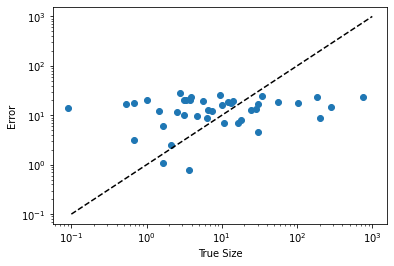

In [90]:
from sklearn.linear_model import LinearRegression

linModel = LinearRegression().fit(x_train, y_train)

linPred = linModel.predict(x_test)

# plt.scatter(y_test, linPred - y_test)
plt.scatter(y_test, linPred)
plt.xlabel('True Size')
plt.ylabel('Error')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
print(mean_absolute_percentage_error(y_test, linPred))

lin_reg_y_test = y_test
lin_reg_pred = linPred

## SVM Regression

sigmoid 89.79921258500525


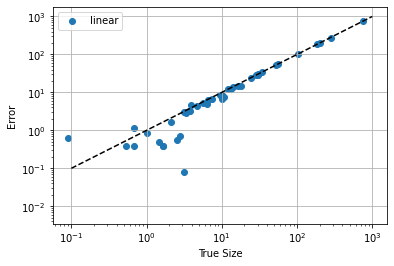

In [92]:
from sklearn.svm import SVR
kernels = ['linear', 'poly', 'rbf', 'sigmoid'];
score = []
for k in ['sigmoid']:
    svmModel = SVR(kernel=k).fit(x_train,y_train)
    svmPredict = svmModel.predict(x_test)
    plt.scatter(y_test, abs(svmPredict - y_test), label = k)
    # plt.scatter(y_test, svmPredict, label = k)
    plt.xlabel('True Size')
    plt.ylabel('Error')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    score.append( mean_absolute_percentage_error(y_test, svmPredict))
    print(k,  mean_absolute_percentage_error(y_test, svmPredict))
    error = svmPredict - y_test
    error_k = np.c_[error_k, error.T]
plt.legend(kernels)
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')    
plt.grid(True)

svm_yx = a
y

<BarContainer object of 4 artists>

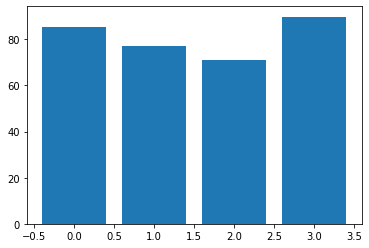

In [60]:
plt.bar([_ for _ in range(4)],score )

## KNN regression

r2_score -0.07651860346683836
knnPredict: ( 10 ) : 3.068964974918853e+16
r2_score -0.01413709478275993
knnPredict: ( 60 ) : 3.1228241291163732e+16
r2_score 0.014829679863094358
knnPredict: ( 110 ) : 3.2941733006206976e+16
r2_score 0.009980821221859504
knnPredict: ( 160 ) : 3.400120555667956e+16
r2_score 0.004136861270117587
knnPredict: ( 210 ) : 3.0798701197308436e+16


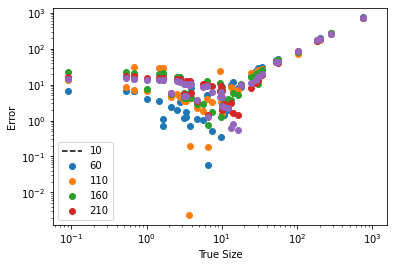

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn import metrics

for i in range(10,211,50):
    knnModel = KNeighborsRegressor(n_neighbors = i).fit(x_train, y_train)
    knnPredict = knnModel.predict(x_test)
    plt.scatter(y_test, abs(knnPredict - y_test))
    plt.xlabel('True Size')
    plt.ylabel('Error')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    print("r2_score", r2_score(y_test, knnPredict))
    print("knnPredict: (", i,") :" ,metrics.mean_absolute_percentage_error(y_test, knnPredict))
plt.plot([.1,20,1000],[0,0,0],c='k',linestyle='--')
plt.legend([ _ for _ in range(10,211,50) ])
# plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')


## Neural network

In [16]:
from sklearn.neural_network import MLPRegressor

nnModel = MLPRegressor(hidden_layer_sizes=(1500,1500,1200,1000,800,400,200),learning_rate='adaptive',batch_size=32,max_iter=10000, verbose=True).fit(x_train, y_train)
nnPredict = nnModel.predict(x_test)

Iteration 1, loss = 2262.63331860
Iteration 2, loss = 1722.25749158
Iteration 3, loss = 1705.00927590
Iteration 4, loss = 1704.54977194
Iteration 5, loss = 1704.29640670
Iteration 6, loss = 1699.14481222
Iteration 7, loss = 1701.04979482
Iteration 8, loss = 1698.51445597
Iteration 9, loss = 1690.84961685
Iteration 10, loss = 1698.07338142
Iteration 11, loss = 1724.18759401
Iteration 12, loss = 1707.10731049
Iteration 13, loss = 1704.25977834
Iteration 14, loss = 1712.72624660
Iteration 15, loss = 1701.64984090
Iteration 16, loss = 1696.81988309
Iteration 17, loss = 1689.62356909
Iteration 18, loss = 1690.56207115
Iteration 19, loss = 1689.41351313
Iteration 20, loss = 1701.91948461
Iteration 21, loss = 1688.29942776
Iteration 22, loss = 1698.80089385
Iteration 23, loss = 1677.19423858
Iteration 24, loss = 1685.85095905
Iteration 25, loss = 1702.90718148
Iteration 26, loss = 1689.50954599
Iteration 27, loss = 1695.91410349
Iteration 28, loss = 1693.41785039
Iteration 29, loss = 1686.687

r2_score -0.013288272731973194
nnPredict:  503.35703671134075


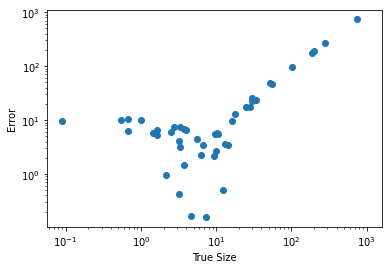

In [71]:
plt.scatter(y_test, abs(nnPredict - y_test))
# plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.plot([.1,20,1000],[0,0,0],c='k',linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('True Size')
plt.ylabel('Error')
print("r2_score", r2_score(y_test, nnPredict))
print("nnPredict: ",mean_absolute_percentage_error(y_test, nnPredict))